# 가짜연구소 4기 - 추천시스템 톺아보기
## LDA와 Item2Vec를 활용한 추천
- 작성자: 김민수(kimminsu.ds@gmail.com)
- 데이터 출처: https://archive.ics.uci.edu/ml/datasets/online+retail#

#### Abstract
- This is a transaction data set which contains all the transactions occuring between 01/12/2010 and 09/12/2011 for a UK-based registered non-store online retail

#### Attritbute Information
- InvoiceNo: Invoce number
    - If this code starts with letter 'C', it indicates a cancellation
- StockCode: Product(item) code
- Description: Product(item) name
- Quantity: The quantities of each product (item) per transaction
- InvoceDate: The day and time when each transaction was generated
- UnitPrice: Product price per unit in sterling
- CustomerID: Customer number
- Country: The name of country where each customer resides

## 00. 환경설정

### 00-01. 패키지

In [2]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

### 00-02. UCI Online  retail 데이터

In [2]:
path = "../data/online retail.csv"
parse_date = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M')
df = pd.read_csv(path, parse_dates=['InvoiceDate'], date_parser=parse_date)

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### 일부 데이터 제외
- 사용자 아이디가 없는 데이터 제외
- quantity가 음수인 데이터 제외

In [4]:
df2 = df[~(df.CustomerID.isnull()) & (df.Quantity > 0)]
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### 전처리

In [5]:
stock_to_description = {row["StockCode"] : row["Description"] for _, row in df2.iterrows()}

In [6]:
df2['CustomerId'] = df2.CustomerID.astype(int)
df2['StockCode']  = df2['StockCode'].astype("str")
df2 = df2[['InvoiceNo', 'StockCode', 'Quantity', 'CustomerID', 'InvoiceDate']]
df2['ym'] = df2['InvoiceDate'].apply(lambda x: str(x)[:7])

#### 전체 기간 데이터 확인

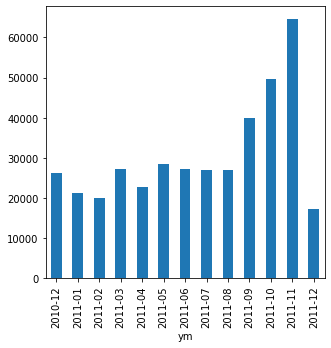

In [7]:
df2.groupby(['ym'])['StockCode'].count().plot.bar(figsize=(5, 5))
plt.show()

#### 데이터셋 분리
- train: **`2011년 09월 ~ 201111월`** 
- test: **`2011년 12월`**

In [8]:
df2['ym'] = df2['InvoiceDate'].apply(lambda x: str(x)[:7])
train_df = df2[(df2['ym'] >= '2011-09') & (df2['ym'] <= '2011-11')]
test_df  = df2[df2['ym'] == '2011-12']

#### 문서 생성

In [9]:
train_groupby = train_df.groupby(['CustomerID'])
doc_list = []

for user_id, user_df in train_groupby:
    document = user_df['StockCode'].values.tolist()
    doc_list.append(document)

In [10]:
doc_list[0]

['23480',
 '21265',
 '21636',
 '22372',
 '22375',
 '22371',
 '22374',
 '22252',
 '22945',
 '22423',
 '23173',
 '47580',
 '47567B',
 '47559B',
 '22698',
 '22697',
 '84558A',
 '23084',
 '21731',
 '23177',
 '21791',
 '23508',
 '23506',
 '23503',
 '22992',
 '22561',
 '22492',
 '22621',
 '23146',
 '23421',
 '23422',
 '23420',
 '22699',
 '22725',
 '22728',
 '22726',
 '22727',
 '21976',
 '22417',
 '23308',
 '84991',
 '84992',
 '22196',
 '22195',
 '20719',
 '23162',
 '22131']

#### gensim Dictionary 형태로 변환

In [11]:
id2word = corpora.Dictionary(doc_list)
id2word

- (예) StockCode 20719 값이 0번으로 매칭

In [12]:
id2word[0]

'20719'

#### 문서를 TF(Term Frequency)의 형태로 변환
- doc_list[0] 유저는 20719(0)을 한 번 구매했으므로 (0, 1)

In [13]:
corpus = [id2word.doc2bow(doc) for doc in doc_list]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)]


## 01. Gensim 패키지를 활용한 LDA 모델링
- [models.ldamodel – Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamodel.html)

#### K는 20으로 지정

In [14]:
topic_num = 20

ldamodel = gensim.models.ldamodel.LdaModel(corpus,
                                          num_topics = topic_num,
                                          id2word = id2word,
                                          passes=10,
                                          per_word_topics=True)

#### 0번 Topic의 연관도 Top 5 단어 확인

In [15]:
topic = 0
topn = 5

for id, prob in ldamodel.get_topic_terms(topic, topn=topn):
    print(ldamodel.id2word[id], prob)

23293 0.040483784
23295 0.03846333
23296 0.03489922
23307 0.033661783
23294 0.033576977


#### Topic별 Top 5 단어 출력

In [16]:
topics = ldamodel.print_topics(num_words = 5)
for topic in topics:
    print(topic)

(0, '0.040*"23293" + 0.038*"23295" + 0.035*"23296" + 0.034*"23307" + 0.034*"23294"')
(1, '0.013*"22865" + 0.012*"22866" + 0.012*"22633" + 0.012*"23439" + 0.011*"21034"')
(2, '0.011*"20727" + 0.010*"22383" + 0.007*"20725" + 0.007*"23321" + 0.006*"23583"')
(3, '0.039*"22138" + 0.032*"84946" + 0.022*"22617" + 0.021*"22178" + 0.019*"84947"')
(4, '0.017*"POST" + 0.011*"23256" + 0.010*"22629" + 0.010*"22551" + 0.010*"23084"')
(5, '0.028*"22998" + 0.025*"21498" + 0.020*"M" + 0.020*"21497" + 0.019*"21500"')
(6, '0.030*"22726" + 0.028*"22727" + 0.022*"22728" + 0.016*"22730" + 0.011*"22993"')
(7, '0.010*"22585" + 0.008*"22398" + 0.008*"21992" + 0.008*"23169" + 0.007*"21791"')
(8, '0.016*"85123A" + 0.012*"23126" + 0.012*"22144" + 0.012*"22271" + 0.012*"22940"')
(9, '0.029*"23355" + 0.023*"22112" + 0.019*"22114" + 0.018*"23284" + 0.017*"22111"')
(10, '0.033*"85099B" + 0.032*"23203" + 0.025*"23344" + 0.024*"23209" + 0.022*"23202"')
(11, '0.024*"22577" + 0.022*"22578" + 0.016*"22579" + 0.009*"21810"

In [17]:
for i in range(20):
    recommend = ldamodel.show_topic(topicid=i, topn=5)
    print(i, [stock_to_description[item] for item, score in recommend])

0 ['SET OF 12 FAIRY CAKE BAKING CASES', 'SET OF 12 MINI LOAF BAKING CASES', 'SET OF 6 TEA TIME BAKING CASES', 'SET OF 60 PANTRY DESIGN CAKE CASES ', 'SET OF 6 SNACK LOAF BAKING CASES']
1 ['HAND WARMER OWL DESIGN', 'HAND WARMER SCOTTY DOG DESIGN', 'HAND WARMER UNION JACK', 'HAND WARMER RED LOVE HEART', 'REX CASH+CARRY JUMBO SHOPPER']
2 ['LUNCH BAG  BLACK SKULL.', 'LUNCH BAG SUKI DESIGN ', 'LUNCH BAG RED RETROSPOT', 'SMALL WHITE HEART OF WICKER', 'LUNCH BAG PAISLEY PARK  ']
3 ['BAKING SET 9 PIECE RETROSPOT ', 'ANTIQUE SILVER T-LIGHT GLASS', 'BAKING SET SPACEBOY DESIGN', 'VICTORIAN GLASS HANGING T-LIGHT', 'ANTIQUE SILVER TEA GLASS ENGRAVED']
4 ['POSTAGE', 'CHILDRENS CUTLERY SPACEBOY ', 'SPACEBOY LUNCH BOX ', 'PLASTERS IN TIN SPACEBOY', 'RABBIT NIGHT LIGHT']
5 ['TRAVEL CARD WALLET KEEP CALM', 'RED RETROSPOT WRAP ', 'Manual', 'FANCY FONTS BIRTHDAY WRAP', 'PINK POLKADOT WRAP ']
6 ['ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE RED ', 'ALARM CLOCK BAKELIKE PINK', 'ALARM CLOCK BAKELIKE IV

#### 유저 Topic별 분포
- (예): 12682번 유저

In [18]:
user_topic_dict = {}
for user_id, user_df in train_groupby:
    document = user_df['StockCode'].values.tolist()
    user_topic_dict[user_id] = ldamodel.get_document_topics(id2word.doc2bow(document), minimum_probability=0.0)

In [19]:
user_id = 12682
user_topic_dict[user_id]

[(0, 0.00035468693),
 (1, 0.0003546869),
 (2, 0.0003546869),
 (3, 0.0003546869),
 (4, 0.5287927),
 (5, 0.013791497),
 (6, 0.124395534),
 (7, 0.0003546869),
 (8, 0.10749814),
 (9, 0.0003546869),
 (10, 0.18053775),
 (11, 0.0003546869),
 (12, 0.0003546869),
 (13, 0.0003546869),
 (14, 0.0003546869),
 (15, 0.040018767),
 (16, 0.0003546869),
 (17, 0.0003546869),
 (18, 0.0003546869),
 (19, 0.0003546869)]

In [20]:
weight_sum = 0
for topic, weight in user_topic_dict[user_id]:
    weight_sum += weight
    
weight_sum

0.9999999787833076

#### Perplexity 계산 - Perplexity가 낮을수록 좋은 모델

In [21]:
print("Perplexity: ",  ldamodel.log_perplexity(corpus))

Perplexity:  -7.347238049526462


#### pyLDAvis 패키지를 활용한 시각화

In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.032139  0.020898       1        1  8.457977
9      0.159164  0.151524       2        1  8.206010
11     0.162220  0.112225       3        1  8.043681
15     0.207673  0.071748       4        1  7.930923
4     -0.176232 -0.044011       5        1  7.098545
1      0.016781 -0.039227       6        1  6.903248
6     -0.143876  0.062143       7        1  6.565436
2      0.056516 -0.169388       8        1  5.565540
14    -0.065299  0.054917       9        1  5.554163
18    -0.096973  0.197693      10        1  5.436208
16     0.226592 -0.132887      11        1  5.028546
19    -0.164653  0.088360      12        1  4.403188
13    -0.178533 -0.031858      13        1  3.680425
12     0.176260 -0.047783      14        1  3.301718
0     -0.075134  0.029745      15        1  3.085628
3      0.034919  0.120401      16        1  3.063332
8      0.022743  0.010518      17        1  2.944748
7      0.006485 -0.100867      18        1  2.271202
5     -0.055536 -0.326836      19        1  1.562263
17    -0.145256 -0.027316      20        1  0.897221, topic_info=    Category        Freq    Term       Total  loglift  logprob
424  Default  501.000000   23203  501.000000  30.0000  30.0000
331  Default  542.000000  85099B  542.000000  29.0000  29.0000
23   Default  338.000000   22726  338.000000  28.0000  28.0000
96   Default  286.000000   23293  286.000000  27.0000  27.0000
98   Default  228.000000   23295  228.000000  26.0000  26.0000
..       ...         ...     ...         ...      ...      ...
603  Topic20   10.279674   22910  481.279022   0.8673  -4.9018
335  Topic20    8.778773   20749  128.287369   2.0317  -5.0596
594  Topic20    8.895153   22086  728.480469   0.3082  -5.0464
308  Topic20    8.594003   23390  146.407959   1.8783  -5.0809
73   Topic20    8.587943   22555  183.961700   1.6493  -5.0816

[1238 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2630      5  0.809775  10133
888       3  0.091629  15036
888       5  0.137444  15036
888       7  0.183258  15036
888       8  0.015272  15036
...     ...       ...    ...
49       11  0.042047   POST
49       13  0.003822   POST
49       15  0.053514   POST
49       16  0.034402   POST
49       19  0.003822   POST

[5519 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 10, 12, 16, 5, 2, 7, 3, 15, 19, 17, 20, 14, 13, 1, 4, 9, 8, 6, 18])

## 02. LDA를 활용한 추천

### 유저 Topic 분포 중 확률이 높은 Topic을 이용한 추천
- 유저의 Topic 분포를 확인하고 가장 확률이 높은 Topic을 선택
- 해당 Topic에 속한 Top N개 아이템을 추천
- (예) 12682번 유저, N: 20

In [23]:
topn = 20
user_id = 12682
user_topics = user_topic_dict[user_id]
user_topics = sorted(user_topics, key=lambda x: (x[1]), reverse=True)
user_topics

[(4, 0.5287927),
 (10, 0.18053775),
 (6, 0.124395534),
 (8, 0.10749814),
 (15, 0.040018767),
 (5, 0.013791497),
 (0, 0.00035468693),
 (1, 0.0003546869),
 (2, 0.0003546869),
 (3, 0.0003546869),
 (7, 0.0003546869),
 (9, 0.0003546869),
 (11, 0.0003546869),
 (12, 0.0003546869),
 (13, 0.0003546869),
 (14, 0.0003546869),
 (16, 0.0003546869),
 (17, 0.0003546869),
 (18, 0.0003546869),
 (19, 0.0003546869)]

In [24]:
user_topic = user_topics[0][0]
user_topic

4

In [25]:
recommend = ldamodel.show_topic(topicid = user_topic, topn=topn)
recommend = [item for item, score in recommend]
recommend

['POST',
 '23256',
 '22629',
 '22551',
 '23084',
 '23389',
 '23367',
 '22382',
 '22554',
 '23368',
 '21731',
 '22630',
 '23254',
 '22326',
 '23480',
 '23506',
 '84997D',
 '23290',
 '23292',
 '23390']

#### 실제 12682번 유저가 test 데이터에서 구매한 아이템

In [26]:
relevant = test_df[test_df['CustomerID'] == user_id]['StockCode'].unique()
list(relevant)

['20750',
 '21931',
 '85099B',
 '22423',
 '21242',
 '21243',
 '21239',
 '21240',
 '23040',
 '22596',
 '22456',
 '48185',
 '21770',
 '21977',
 '21212',
 '84375',
 '23163',
 '84378',
 '23020',
 '22966',
 '23084',
 '22556',
 '22551',
 '22555',
 '47566',
 '23192',
 '22139',
 '22138',
 '22467',
 'POST']

#### 성능지표 확인

In [27]:
def get_precision(relevant, recommend):
    _intersection = set(recommend).intersection(set(relevant))
    return len(_intersection) / len(recommend)

print("Preicision: {}".format(get_precision(relevant, recommend)))

Preicision: 0.15


In [28]:
def get_recall(relevant, recommend):
    _intersection = set(recommend).intersection(set(relevant))
    return len(_intersection) / len(relevant)

print("Recall: {}".format(get_recall(relevant, recommend)))

Recall: 0.1


### Top N 추천 성능 평가
- 모든 유저별로 추천하여 전체 성능 확인

In [29]:
train_user_ids = train_df['CustomerID'].unique()
test_user_ids  = test_df['CustomerID'].unique()
topn = 20

default_recommend = list(train_df.groupby('StockCode')['Quantity'].count().sort_values(ascending=False)[:topn].index)

precisions = []
recalls = []

for user_id in test_user_ids:
    if user_id in train_user_ids:
        user_topics = user_topic_dict[user_id]
        user_topics = sorted(user_topics, key=lambda x: (x[1]), reverse=True)
        user_topic  = user_topics[0][0]
        recommend = [item for item, score in ldamodel.show_topic(topicid = user_topic, topn=topn)]
    else:
        recommend = default_recommend
        
    relevant = test_df[test_df['CustomerID'] == user_id]['StockCode'].unique()
    precisions.append(get_precision(relevant, recommend))
    recalls.append(get_recall(relevant, recommend))
    
print("precision@k:", np.mean(np.asarray(precisions)))
print("recall@k:", np.mean(np.asarray(recalls)))

precision@k: 0.10658536585365856
recall@k: 0.12250385424018778


## 03. Item2Vec 기반 추천

### 03-00. 환경설정

In [10]:
import seaborn as sns

from sklearn.model_selection import train_test_split

### 03-01. MovieLens 데이터
- 유저 혹은 세션 단위로 비슷한 의도를 가지고 아이템을 소비한 로그 데이터

In [4]:
movies_df = pd.read_csv("../data/MovieLens/movies.csv")
ratings_df = pd.read_csv("../data/MovieLens/ratings.csv")

movie_id_to_name = pd.Series(movies_df.title.values, index = movies_df.movieId.values).to_dict()
name_to_movie_id = pd.Series(movies_df.movieId.values, index = movies_df.title).to_dict()

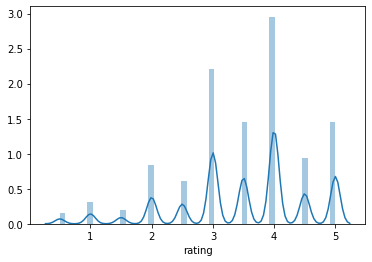

In [7]:
sns.distplot(ratings_df['rating'])
plt.show()

#### 평점이 4점 이상일 경우 영화를 선호(1)하는 경우로 가정

In [11]:
ratings_df['liked'] = np.where(ratings_df['rating'] >= 4, 1, 0)
ratings_df['movieId'] = ratings_df['movieId'].astype("str")

#### userId를 기준으로 train/test셋 분리

In [ ]:
train_df, test_df = train_test_split(ratings_df, stratify = ratings_df['userId'], random_state=100, test_size=0.2)

In [12]:
train_df.head()

,userId,movieId,rating,timestamp,liked
78097,484,3911,4.0,1342294787,1
34543,232,48877,3.5,1163024515,0
94410,599,26940,2.5,1519346264,0
85385,555,724,5.0,978745225,1
78341,487,31658,3.5,1428574498,0


In [13]:
test_df.head()

,userId,movieId,rating,timestamp,liked
35693,240,595,3.0,849122129,0
31304,217,2381,3.0,955945401,0
73090,473,48322,3.5,1169351800,0
80405,509,838,3.5,1436031723,0
41059,278,2427,4.5,1193753136,1


In [14]:
print("number of train data:", len(train_df))
print("number of test  data:", len(test_df))

number of train data: 80668
number of test  data: 20168


#### 한 명의 user를 기준으로 평점 4점 이상인 영화와 4점 미만으로 평가한 영화를 나누어 각각 Item2Vec 임베딩에 사용

In [15]:
user_grouped = train_df.groupby(['liked', 'userId'])
user_movie_list = [user_grouped.get_group(gp)['movieId'].tolist() for gp in user_grouped.groups]

- (예) 0번 유저 학습데이터

In [16]:
user_movie_list[0]

['673',
 '3176',
 '423',
 '223',
 '70',
 '2617',
 '2414',
 '1219',
 '2338',
 '2253',
 '2389',
 '3243',
 '1445',
 '1644',
 '2528',
 '3247',
 '1408',
 '1030',
 '500',
 '2093',
 '1676',
 '1377',
 '736',
 '316']

- 학습에 사용되는 유저: 1215명

In [17]:
len(user_movie_list)

1215

### 03-02. Gensim 패키지를 활용한 Item2Vec 임베딩
- [models.word2vec - Word2vec embeddings](https://radimrehurek.com/gensim/models/word2vec.html)

In [18]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(sentences = user_movie_list,
                 epochs = 5,
                 vector_size = 100,
                 min_count = 3,     # 단어가 최소 3회 이상 등장해야 학습되고 모델에 저장됨 
                 workers = 4,
                 sg = 1,            # skip-gram을 사용한다면 1
                 hs = 0,            # negative sampling을 사용한다면 0 (hierarchical softmax)
                 negative = 5,      # 1개의 positive sample 당 negative sample의 개수
                 window = 9999999   # Window를 크게 잡는 이유는 문장 내 모든 아이템끼리 학습이 되어야 하기 때문
                )

word_vectors = model.wv

#### 임베딩된 아이템의 결과 - (예) 30793

In [19]:
word_vectors['30793']

array([-0.01744325,  0.08125577,  0.18903896,  0.11664012,  0.2714088 ,
        0.14623685,  0.12377597, -0.0587979 ,  0.03206313, -0.01576859,
        0.11863975,  0.19497389, -0.05112956,  0.00434615,  0.23034671,
        0.11031938, -0.2170089 , -0.15399076, -0.2953926 , -0.07981212,
        0.34707573,  0.19277492,  0.16233066, -0.13425882, -0.25216034,
        0.20503443, -0.0575765 ,  0.11880486, -0.37460202, -0.04001546,
        0.31542915,  0.14041017,  0.30797255,  0.2091136 ,  0.28465226,
       -0.16445017,  0.04560117,  0.08365401, -0.07953838, -0.20544879,
       -0.15094332,  0.00298955,  0.04422513, -0.27350244,  0.14118843,
       -0.56635976, -0.2145646 ,  0.14701265,  0.02652693, -0.03586416,
        0.23299031, -0.29511413,  0.04784491,  0.0143843 , -0.18328175,
        0.05197632, -0.12598038, -0.11479893,  0.03020596, -0.13311692,
        0.2373667 , -0.00090552,  0.27393687, -0.00957653, -0.07691379,
        0.20747848,  0.20110992,  0.0815099 , -0.07781699,  0.24

- **`vector_size=100`**이므로 100차원으로 임베딩

In [20]:
len(word_vectors['30793'])

100

### 03-03. Item2Vec 결과 확인

#### 예시: 30793(찰리와 초콜릿 공장)

In [21]:
movies_df[movies_df.movieId==30793]

,movieId,title,genres
5735,30793,Charlie and the Chocolate Factory (2005),Adventure|Children|Comedy|Fantasy|IMAX


#### 30793과 코사인 유사도가 가장 높은 10개의 아이템 생성
- **`model.wv.most_similar()`**

In [22]:
topn = 10
positive_list = ['30793']
similar_movies = model.wv.most_similar(positive=positive_list, topn=topn)
similar_movie_list = [movie_id for movie_id, score in similar_movies]
movies_df[movies_df['movieId'].isin(similar_movie_list)]

,movieId,title,genres
905,1203,12 Angry Men (1957),Drama
4356,6373,Bruce Almighty (2003),Comedy|Drama|Fantasy|Romance
5173,8376,Napoleon Dynamite (2004),Comedy
5265,8644,"I, Robot (2004)",Action|Adventure|Sci-Fi|Thriller
6112,42734,Hoodwinked! (2005),Animation|Children|Comedy
6149,44022,Ice Age 2: The Meltdown (2006),Adventure|Animation|Children|Comedy
6208,45447,"Da Vinci Code, The (2006)",Drama|Mystery|Thriller
6530,54272,"Simpsons Movie, The (2007)",Animation|Comedy
7144,71462,"Cove, The (2009)",Documentary
7742,90888,Immortals (2011),Action|Drama|Fantasy


#### 2개 이상의 아이템에 대해서는 해당 아이템 벡터들의 element-wise 평균을 구하여 코사인 유사도 계산

In [23]:
movies_df[movies_df['movieId'].isin([50912, 56941])]

,movieId,title,genres
6406,50912,"Paris, I Love You (Paris, je t'aime) (2006)",Romance
6657,56941,P.S. I Love You (2007),Comedy|Drama|Romance


In [24]:
topn = 10
positive_list = ['50912', '56941']
similar_movie_list = [movie_id for movie_id, score in model.wv.most_similar(positive=positive_list, topn=topn)]
movies_df[movies_df['movieId'].isin(similar_movie_list)]

,movieId,title,genres
3159,4248,Josie and the Pussycats (2001),Comedy
6217,45666,Nacho Libre (2006),Comedy
6457,52319,Inglorious Bastards (Quel maledetto treno blin...,Action|Adventure|Drama|War
6756,59725,Sex and the City (2008),Comedy|Romance
7188,72407,"Twilight Saga: New Moon, The (2009)",Drama|Fantasy|Horror|Romance|Thriller
7351,78316,Letters to Juliet (2010),Drama|Romance
7716,90376,We Need to Talk About Kevin (2011),Drama|Thriller
7988,96821,"Perks of Being a Wallflower, The (2012)",Drama|Romance
8994,139642,Southpaw (2015),Action|Drama
9009,140174,Room (2015),Drama


### 03-04. Item2Vec 기반 추천
- 유저에게 추천을 수행할 때는 유저가 선호했던 아이템을 positive_list로 사용
- 이 때 모델 하이퍼파라미터와 min_count로 인해 word2vec 모델이 학습되지 않은 아이템은 제외

In [25]:
_df = train_df[train_df['liked'] == 1]
_df = _df[_df.movieId.isin(model.wv.index_to_key)]
user_liked_train_movies = _df.groupby('userId').agg({'movieId': lambda x: x.tolist()})['movieId'].to_dict()

In [26]:
_df = test_df[test_df['liked'] == 1]
user_liked_test_movies = _df.groupby('userId').agg({'movieId': lambda x: x.tolist()})['movieId'].to_dict()

#### 전체 유저에 대해 Item2Vec 기반 영화 추천

In [27]:
topn = 20
precisions = []
recalls = []
cold_start = 0

for user_id, liked_items in user_liked_test_movies.items():
    
    if user_id in user_liked_train_movies:
        # test 데이터에서 선호한 아이템
        relevant = liked_items
        
        # train 데이터에서 선호한 아이템 리스트를 사용하여
        # Item2Vec 모델을 통해 추천 아이템을 생성합니다.
        
        train_liked_items = user_liked_train_movies[user_id]
        recommend = [movie_id for movie_id, score in model.wv.most_similar(positive = train_liked_items, topn=topn)]
    
    # test 데이터의 유저가 train에 없는 경우에는 건너뜁니다.
    else:
        cold_start += 1
        continue
        
    intersect = set(relevant).intersection(set(recommend))
    precision = len(intersect) / len(recommend)
    recall = len(intersect) / len(relevant)
    
    precisions.append(precision)
    recalls.append(recall)
    
print("precision@k:", np.mean(np.asarray(precisions)))
print("recall@k:", np.mean(np.asarray(recalls)))
print("cold_start_user:", cold_start)

precision@k: 0.0661397670549085
recall@k: 0.15092190184832857
cold_start_user: 0


#### 예시 - 610번 유저

In [29]:
print(user_id)

610


- **`train_liked_items`**: 610번 유저가 train셋에서 선호했던 영화

In [34]:
print(len(train_liked_items))

410


In [35]:
print(train_liked_items)

['78039', '102123', '38095', '106766', '72226', '4776', '55820', '5669', '2076', '3925', '89753', '70', '168250', '5577', '152081', '464', '60766', '55118', '2985', '112', '3911', '57504', '58559', '44828', '115210', '3016', '6731', '68157', '57669', '40278', '4902', '69481', '48774', '59022', '110', '4896', '1358', '110102', '112290', '593', '1', '93838', '68358', '130634', '54503', '3481', '1197', '592', '1214', '61024', '4553', '97938', '116823', '1276', '139644', '1241', '5349', '74458', '4725', '112623', '34323', '3468', '5502', '95875', '58998', '4437', '55280', '92420', '5909', '114935', '7153', '6807', '1213', '51662', '139385', '3328', '61132', '66097', '102125', '166528', '81932', '103341', '168248', '38038', '6620', '1300', '55290', '103772', '95088', '4848', '96079', '111781', '8366', '106487', '377', '1273', '480', '56367', '8636', '164179', '88163', '3300', '7981', '1258', '135133', '27317', '116799', '5630', '128360', '46578', '52241', '7451', '5064', '166534', '923', '9

- **`relevant`**: 610번 유저가 test셋에서 선호했던 영화

In [37]:
print(len(relevant))

125


In [38]:
print(relevant)

['26603', '26612', '457', '1279', '94959', '4794', '68952', '88129', '102760', '47465', '5952', '91500', '140174', '79091', '76093', '95858', '5445', '3726', '1967', '5254', '3751', '1089', '1527', '122892', '54259', '6365', '79702', '77893', '71264', '3535', '8917', '5833', '143859', '8042', '380', '143385', '5010', '74228', '51540', '59727', '1218', '54001', '1201', '47', '78836', '6063', '4973', '4027', '39381', '27584', '1222', '56174', '82459', '1249', '70208', '152077', '103685', '108729', '3018', '106920', '27592', '34450', '1129', '194', '112183', '3108', '1215', '147657', '59315', '5617', '93840', '91077', '6296', '8142', '86142', '2716', '112852', '735', '2916', '44597', '97188', '5110', '8950', '122886', '30812', '51709', '160527', '88125', '2161', '52952', '47404', '27563', '7022', '122882', '89118', '1923', '95441', '115727', '54286', '104457', '231', '1090', '1240', '64839', '1136', '115569', '129313', '3114', '142598', '8798', '81132', '441', '73876', '2000', '158238', '

- **`recommend`**: Item2Vec 기반 추천 영화

In [40]:
print(len(recommend))

20


In [41]:
print(recommend)

['102993', '38304', '187541', '96432', '99813', '103372', '96020', '73319', '86347', '112421', '98124', '63113', '2495', '106642', '5120', '152970', '27728', '90376', '93831', '62250']


- 추천 결과가 테스트 데이터에 속해있지 않음

In [43]:
set(relevant) & set(recommend)

set()